In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

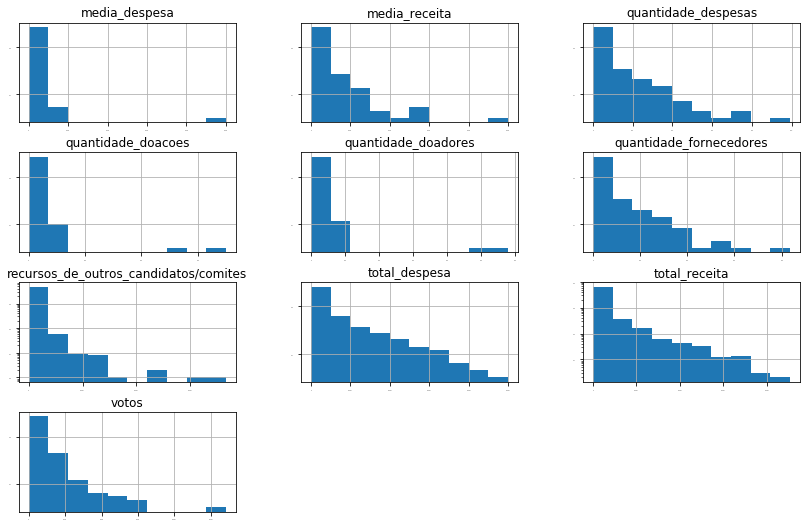

In [2]:
# Dados referentes as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010.
points = pd.read_csv("../data/eleicoes_2006_a_2010.csv")

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)

#histograma das variáveis numéricas
dist_feats = pd.DataFrame({ "quantidade_doacoes":points["quantidade_doacoes"],
                            "quantidade_doadores":points["quantidade_doadores"],
                            "total_receita":points["total_receita"],
                            "media_receita":points["media_receita"],
                            "recursos_de_outros_candidatos/comites":points["recursos_de_outros_candidatos/comites"],
                            "quantidade_despesas":points["quantidade_despesas"],
                            "quantidade_fornecedores":points["quantidade_fornecedores"],
                            "total_despesa":points["total_despesa"],
                            "media_despesa":points["media_despesa"],
                            "votos":points["votos"]
                          })

hits = dist_feats.hist(log=True, xlabelsize=0, ylabelsize=0)                

* Todos os atributos numéricos possuem viés para direita, neste caso é preciso normalizar-los
* Atributos irrelevantes como `sequencial_candidato` e `nome` podem ser removidos  
* Os dados de treino e validação correspondem as eleições de 2006 e 2010 e foram particionados em 75% e 25% respectivamente
* Valores faltantes foram substituídos pela média do respectivo atributo

In [3]:
#merge dos dados de 2006 a 2014
points = pd.concat((points, pd.read_csv("../data/eleicoes_2014.csv")))

#removendo variáveis irrelevantes ou redundantes
points = points.drop(columns=['sequencial_candidato', 'nome', 'media_receita', 'media_despesa'])

#calculando skew
# skewed_feats = points[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

#filling NA's with the mean of the column:
#points = points.fillna(points.median())
points = points.fillna('')

#selecionando atributos numéricos
numeric_feats = points.dtypes[points.dtypes != "object"].index

#normalizando atributos numéricos exceto ano
points[numeric_feats[1 :]] = np.log1p(points[numeric_feats[1:]])

#convertendo variáveis categóricas em dummy
points = pd.get_dummies(points)

#filtrando dados de 2006 e 2010
X = points.loc[points['ano'] != 2014].drop(columns=['votos'])
Y = points.loc[points['ano'] != 2014].votos

#particionando dados treino 75% e validação 25%
from sklearn.model_selection import train_test_split
train, validation, y_train, y_validation = train_test_split(X, Y, random_state = 8)

Função para calcular o rmse na validação cruzada

In [7]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

### Regressão Linear Múltipla

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_linear = LinearRegression()
rmse_cv(reg_linear).mean()

240036948.39376822

### Ridge

In [8]:
from sklearn.linear_model import Ridge

alphas_ridge = np.arange(0.5,20,0.5).tolist()

cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]

cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

KeyboardInterrupt: 

### Lasso

Text(0,0.5,'rmse')

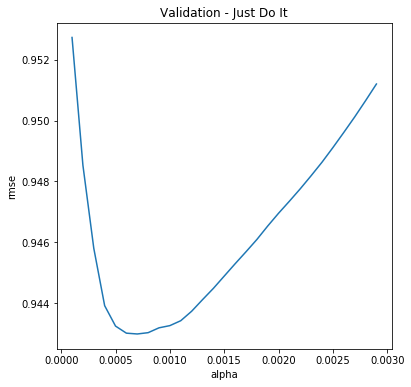

In [7]:
from sklearn.linear_model import Lasso
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()

cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=8000)).mean() 
            for alpha in alphas_lasso]


cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

### KNN

Text(0,0.5,'rmse')

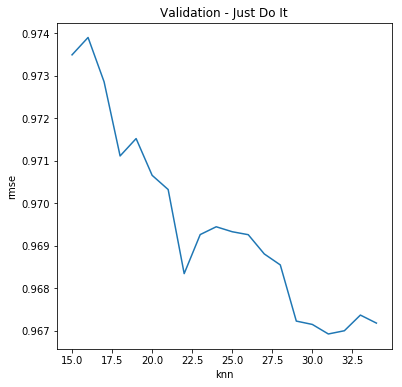

In [8]:
from sklearn.neighbors import KNeighborsRegressor

neighbors = np.arange(15,35,1).tolist()

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=neighbor)).mean() 
            for neighbor in neighbors]

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_knn = pd.Series(cv_knn, index = neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("knn")
plt.ylabel("rmse")

### Decision Tree Regressor

Text(0,0.5,'rmse')

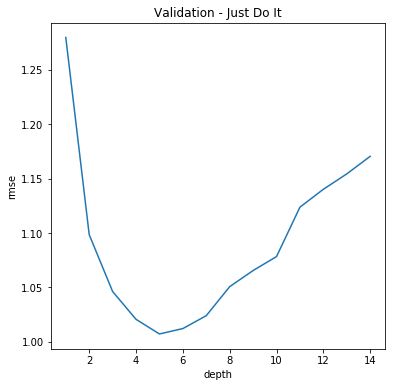

In [9]:
from sklearn.tree import DecisionTreeRegressor

depths = np.arange(1,15,1).tolist()

cv_treeregressor = [rmse_cv(DecisionTreeRegressor(max_depth = depth )).mean() 
            for depth in depths]

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
cv_treeregressor = pd.Series(cv_treeregressor, index = depths)
cv_treeregressor.plot(title = "Validation - Just Do It")
plt.xlabel("depth")
plt.ylabel("rmse")

# Resíduos versus Predições

### Regressão Linear

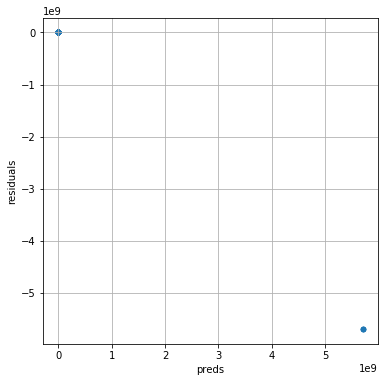

In [10]:
model_reg_linear = LinearRegression().fit(train, y_train)
preds = pd.DataFrame({"preds": model_reg_linear.predict(validation), "true":y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

### Ridge

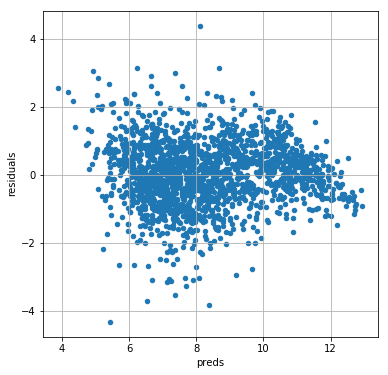

In [11]:
model_ridge = Ridge(alpha = cv_ridge.idxmin()).fit(train, y_train)
preds = pd.DataFrame({"preds": model_ridge.predict(validation), "true":y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

### Lasso

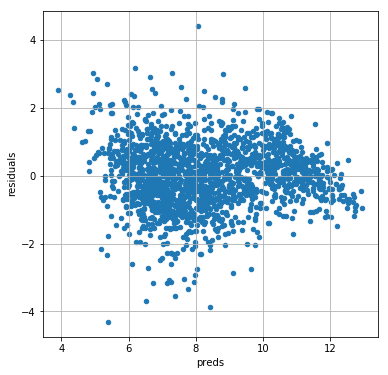

In [12]:
model_lasso = Lasso(alpha = cv_lasso.idxmin()).fit(train, y_train)
preds = pd.DataFrame({"preds": model_lasso.predict(validation), "true":y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

### KNN

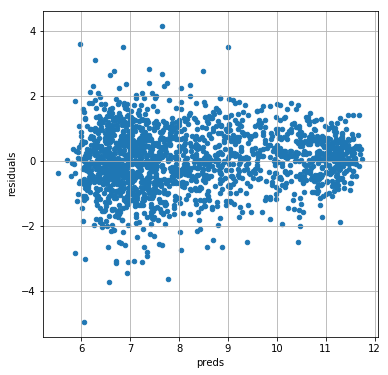

In [13]:
model_knn = KNeighborsRegressor(n_neighbors = cv_knn.idxmin()).fit(train, y_train)
preds = pd.DataFrame({"preds": model_knn.predict(validation), "true":y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

### Decision Tree Regressor

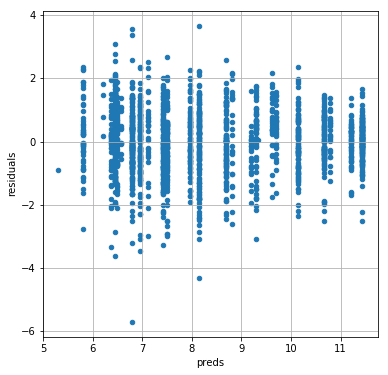

In [14]:
model_tree = DecisionTreeRegressor(max_depth = cv_treeregressor.idxmin()).fit(train, y_train)
preds = pd.DataFrame({"preds": model_tree.predict(validation), "true":y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

# Previsão eleições 2014

In [15]:
#carregando dados de 2014
points_2014 = points.loc[points['ano'] == 2014]

### Ridge

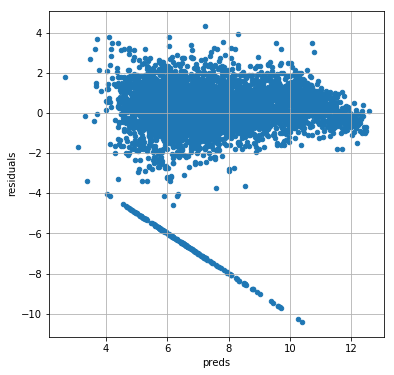

In [16]:
model_ridge = Ridge(alpha = cv_ridge.idxmin()).fit(points.drop(columns=['votos']), points.votos)
preds = pd.DataFrame({"preds": model_ridge.predict(points_2014.drop(columns=['votos'])), "true":points_2014.votos})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

### Lasso

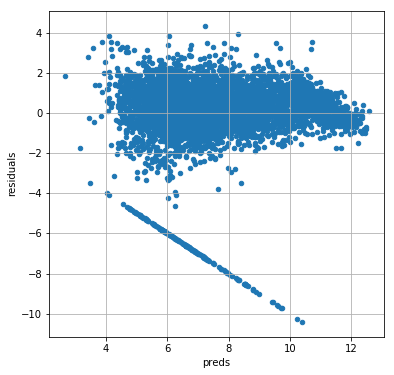

In [17]:
model_Lasso = Lasso(alpha = cv_lasso.idxmin()).fit(points.drop(columns=['votos']), points.votos)
preds = pd.DataFrame({"preds": model_Lasso.predict(points_2014.drop(columns=['votos'])), "true":points_2014.votos})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

In [6]:
X.isnull().any()

ano                                                                                False
quantidade_doacoes                                                                 False
quantidade_doadores                                                                False
quantidade_despesas                                                                False
quantidade_fornecedores                                                            False
total_despesa                                                                      False
uf_AC                                                                              False
uf_AL                                                                              False
uf_AM                                                                              False
uf_AP                                                                              False
uf_BA                                                                              False
uf_CE                